In [89]:
import os
from shutil import copy

#import tensorflow as tf
#import tensorflow.keras
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Conv2D, Input, BatchNormalization
from keras.regularizers import l1
from keras.optimizers import RMSprop, Adagrad, Adam, SGD
from keras.applications import VGG16
from keras.applications.mobilenetv2 import MobileNetV2
from keras.models import load_model, Model
from keras.callbacks import ModelCheckpoint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix

import PIL.Image

from pprint import pprint

# Getting Started

In [48]:
def applyBoundingBox(image, boundingbox):
    x = int(float(boundingbox[0]))
    y = int(float(boundingbox[1]))
    width = int(float(boundingbox[2]))
    height = int(float(boundingbox[3]))
    #print([x, y, width, height])
        
    imagecropped = image[y:y+height,x:x+width]
    
#     print("len(image): ", len(image))
#     print("len(image)[0]: ", len(image[0]))
#     print("len(image)[0][0]: ", len(image[0][0]))
    
#     print("len(imagecropped): ", len(imagecropped))
#     print("len(imagecropped)[0]: ", len(imagecropped[0]))
#     print("len(imagecropped)[0][0]: ", len(imagecropped[0][0]))
    return imagecropped

In [45]:
def copyImage(src, label, tr_te, dst="", image=None):
    
        cat = os.path.join(tr_te, label)
        new_dst = os.path.join(dst,cat)
        
        #print(src)
        #print(cat)
        #print(new_dst)
        
        # check if directory exists
        if os.path.isdir(new_dst):
            pass
        else:        
            # make diretory
            os.mkdir(new_dst)

        #print(new_dst)
        if image is not None:
            file = src.split("/")[-1]
            new_dst = os.path.join(new_dst,file)
            result = PIL.Image.fromarray(image)
            result.save(new_dst)
        else:
            copy(src, new_dst)

In [98]:
#generateData("./CUB_200_2011/CUB_200_2011/CUB_200_2011/train.txt", "./Outex_TC_00030.tar/Outex-TC-00030/images/", "C:/Users/Sophie/Documents/GitHub/CSI5139/csi5139_a2/Outex-TC-00030/test/")

drt = "./CUB_200_2011/CUB_200_2011/CUB_200_2011/"
drt_images = "./CUB_200_2011/CUB_200_2011/CUB_200_2011/images"
dst = "./CUB_200_2011_generator/"
dst_bb = "./CUB_200_2011_generator_boundingbox/"

# images.txt
with open(os.path.join(drt, "images.txt"), "r", encoding='utf-8') as f:
    images_txt = f.read().splitlines()

# train_test_split.txt
with open(os.path.join(drt, "train_test_split.txt"), "r", encoding='utf-8') as f:
    tr_te_txt = f.read().splitlines()

# image_class_labels.txt
with open(os.path.join(drt, "image_class_labels.txt"), "r", encoding='utf-8') as f:
    class_labels_txt = f.read().splitlines()

# bounding_boxes.txt
with open(os.path.join(drt, "bounding_boxes.txt"), "r", encoding='utf-8') as f:
    bounding_boxes_txt = f.read().splitlines()

print(images_txt[:2])
print(tr_te_txt[:2])
print(class_labels_txt[:2])
print(bounding_boxes_txt[:2])
print("# images_txt: ", len(images_txt))
print("# tr_te_txt: ", len(tr_te_txt))
print("# class_labels_txt: ", len(class_labels_txt))
print("# bounding_boxes_txt: ", len(bounding_boxes_txt))

#birdspecies_subset = {"cardinal": 17, "american_goldﬁnch": 47, "evening_grosbeak": 55, "song_sparrow": 129, "tree_sparrow": 130, "house_sparrow": 118, "fox_sparrow":120, "canada_warbler":162, "myrtle warbler": 171, "house_wren": 196 , "red-winged_blackbird": 10, "boat_tailed_grackle":49}
birdspecies_subset = {"17": "cardinal", "47": "american_goldﬁnch", "55": "evening_grosbeak", "129": "song_sparrow", "130": "tree_sparrow", "118": "house_sparrow", "120": "fox_sparrow", "162": "canada_warbler", "171": "myrtle warbler", "196": "house_wren", "10": "red-winged_blackbird", "49": "boat_tailed_grackle"}
label_subset = set(birdspecies_subset.keys())
print("label_subset: ", label_subset)

boundingbox = True
bb_input_train = []
bb_input_test = []
for i, label in enumerate(class_labels_txt):
    label = label.split(' ')[-1]
    if label in label_subset:
        file = images_txt[i].split(' ')[-1]
        tr_te = tr_te_txt[i].split(' ')[-1]
        b_b = bounding_boxes_txt[i].split(' ')[1:]
        
        if tr_te == "1":
            tr_te = "train"
            bb_input_train.append(b_b)
        elif tr_te == "0":
            tr_te = "test"
            bb_input_test.append(b_b)
        else:
            break
        
#         print(file)
#         src = os.path.join(drt_images, file)
        
#         if boundingbox:
#             image = PIL.Image.open(src)
#             image = np.array(image)
#             image = applyBoundingBox(image, b_b)
#             copyImage(file, label, tr_te, dst_bb, image)
#         else:
#             src = os.path.join(drt_images, file)
#             copyImage(src, label, tr_te, dst) 

bb_input_train = np.array(bb_input_train)
bb_input_test = np.array(bb_input_test)

['1 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg', '2 001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg']
['1 0', '2 1']
['1 1', '2 1']
['1 60.0 27.0 325.0 304.0', '2 139.0 30.0 153.0 264.0']
# images_txt:  11788
# tr_te_txt:  11788
# class_labels_txt:  11788
# bounding_boxes_txt:  11788
label_subset:  {'196', '129', '47', '118', '49', '162', '120', '55', '17', '171', '130', '10'}


In [99]:
# drt = "./CUB_200_2011/CUB_200_2011/CUB_200_2011/"
# bb_input = []
# # bounding_boxes.txt
# with open(os.path.join(drt, "bounding_boxes.txt"), "r", encoding='utf-8') as f:
#     bounding_boxes_txt = f.read().splitlines()
    
# print("# bounding_boxes_txt: ", len(bounding_boxes_txt))

# for i, label in enumerate(bounding_boxes_txt):
#     bb = bounding_boxes_txt[i].split(' ')[1:]
#     bb_input.append(bb)
    
print("# bb_input_train: ", len(bb_input_train))
print(bb_input_train[:2])

print("# bb_input_test: ", len(bb_input_test))
print(bb_input_test[:2])

# bb_input_train:  359
[['187.0' '129.0' '131.0' '226.0']
 ['130.0' '124.0' '351.0' '205.0']]
# bb_input_test:  357
[['110.0' '144.0' '171.0' '156.0']
 ['218.0' '39.0' '205.0' '360.0']]


In [134]:
datagen = ImageDataGenerator(rescale=.1/255)

train_batchsize = 32 # 160 images per 68 classes
test_batchsize = 32 # 20 images per 68 classes

train_generator = datagen.flow_from_directory(
    directory=r"./CUB_200_2011_generator/train/",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=train_batchsize,
    class_mode="categorical"
)

test_generator = datagen.flow_from_directory(
    directory=r"./CUB_200_2011_generator/test/",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=test_batchsize,
    class_mode="categorical"
)

print("Train generator length: ", len(train_generator))
print("Test generator length: ", len(test_generator))
print("Target size: ", train_generator.target_size)

Found 359 images belonging to 12 classes.
Found 357 images belonging to 12 classes.
Train generator length:  12
Test generator length:  12
Target size:  (96, 96)


In [111]:
datagen = ImageDataGenerator(rescale=.1/255)

train_batchsize = 359 # 160 images per 68 classes
test_batchsize = 357 # 20 images per 68 classes

train_generator_temp = datagen.flow_from_directory(
    directory=r"./CUB_200_2011_generator/train/",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=train_batchsize,
    class_mode="categorical"
)

test_generator_temp = datagen.flow_from_directory(
    directory=r"./CUB_200_2011_generator/test/",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=test_batchsize,
    class_mode="categorical"
)

print("Train generator length: ", len(train_generator_temp))
print("Test generator length: ", len(test_generator_temp))
print("Target size: ", train_generator_temp.target_size)

Found 359 images belonging to 12 classes.
Found 357 images belonging to 12 classes.
Train generator length:  1
Test generator length:  1
Target size:  (96, 96)


In [114]:
X, y = train_generator_temp.next()
Xtest, ytest = test_generator_temp.next()
print("X: ", X.shape)
print("y: ", y.shape)
print("Xtest: ", Xtest.shape)
print("ytest: ", ytest.shape)

# y = np.array([y, bb_input_train])
# ytest = np.array([ytest, bb_input_test])

# print("Xtest: ", Xtest.shape)
# print("ytest: ", ytest.shape)

X:  (359, 96, 96, 3)
y:  (359, 12)
Xtest:  (357, 96, 96, 3)
ytest:  (357, 12)


# Model

In [135]:
mobilenetv2_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))

# Regularization

Evaluate model for classiﬁcation with three diﬀerent regularizations: dropout, batch normalization and l1-regularization.

In [129]:
epochs = 10

#mobilenetv2_model.summary()
for layer in mobilenetv2_model.layers:
    layer.trainable = False

# last layers output
x = mobilenetv2_model.layers[-1].output

# Flatten as before
x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# Apply dropout and batchnorm
x_dropout = Dropout(0.5)(x)
x_batchnorm = BatchNormalization()(x)

dropout = Dense(12, activation='softmax')(x_dropout)
batchnorm = Dense(12, activation='softmax')(x_batchnorm)

# Apply l1-reg
l1reg = Dense(12, activation='softmax', kernel_regularizer=l1(0.1), activity_regularizer=l1(0.1))(x)

# Transfer models
mv2_dropout_transfer = Model(inputs=mobilenetv2_model.input, outputs=dropout)
mv2_batchnorm_transfer = Model(inputs=mobilenetv2_model.input, outputs=batchnorm)
mv2_l1reg_transfer = Model(inputs=mobilenetv2_model.input, outputs=l1reg)

# SGD optimizer
sgd = SGD()

mv2_dropout_transfer.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
mv2_batchnorm_transfer.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
mv2_l1reg_transfer.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [136]:
epochs = 10

#mobilenetv2_model.summary()
for layer in mobilenetv2_model.layers:
    layer.trainable = False

# last layers output
x = mobilenetv2_model.layers[-1].output
# Flatten as before
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
x = Dense(12, activation='softmax')(x)

# Apply l1-reg
#l1reg = Dense(12, activation='softmax', kernel_regularizer=l1(0.1), activity_regularizer=l1(0.1))(x)

# Transfer models
mv2_transfer = Model(inputs=mobilenetv2_model.input, outputs=x)

# SGD optimizer
sgd = SGD()

mv2_transfer.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
for layer in mv2_dropout_transfer.layers:
    print(layer, layer.trainable)
    
mv2_dropout_transfer.summary()

hist_mv2_dropout = mv2_transfer.fit_generator(
        train_generator,
        steps_per_epoch=(train_generator.samples/train_generator.batch_size),
        epochs=epochs,
        validation_data=train_generator,
        validation_steps=(train_generator.samples/train_generator.batch_size),
        verbose=1)

<keras.engine.input_layer.InputLayer object at 0x000001F9B5357320> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B5AE10B8> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B59466D8> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B5326668> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001F9B5696A20> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B5343710> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B5401160> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B53E3C18> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B52C8668> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B52BD208> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B5268EF0> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B527C5F8> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001F9B524D6A0> 

Epoch 1/10
12/11 [================================] - 72s 6s/step - loss: 2.5504 - acc: 0.2023 - val_loss: 2.8421 - val_acc: 0.0919
Epoch 2/10
12/11 [================================] - 66s 5s/step - loss: 0.6989 - acc: 0.7977 - val_loss: 3.1060 - val_acc: 0.1058
Epoch 3/10
11/11 [============================>.] - ETA: 0s - loss: 0.4660 - acc: 0.8604

#### Dropout

In [61]:
print("batch_size: ", train_generator.batch_size)

for layer in mv2_dropout_transfer.layers:
    print(layer, layer.trainable)
    
mv2_dropout_transfer.summary()

hist_mv2_dropout = mv2_dropout_transfer.fit_generator(
        train_generator,
        steps_per_epoch=(train_generator.samples/train_generator.batch_size),
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=(test_generator.samples/test_generator.batch_size),
        verbose=1)

batch_size:  32
<keras.engine.input_layer.InputLayer object at 0x000001F9B22EA630> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B22F7908> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B22F7BA8> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B22F7DA0> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001F9B22F7C50> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B22CCF98> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B22875F8> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B147CDD8> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B14F6128> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B14E04E0> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B1573EB8> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B15F1748> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x00

Epoch 1/10
12/11 [================================] - 106s 9s/step - loss: 4.6602 - acc: 0.1986 - val_loss: 3.0664 - val_acc: 0.1204
Epoch 2/10
12/11 [================================] - 110s 9s/step - loss: 1.4205 - acc: 0.5715 - val_loss: 3.0974 - val_acc: 0.1008
Epoch 3/10
12/11 [================================] - 112s 9s/step - loss: 0.6661 - acc: 0.7839 - val_loss: 2.9642 - val_acc: 0.1064
Epoch 4/10
12/11 [================================] - 114s 10s/step - loss: 0.5648 - acc: 0.8317 - val_loss: 3.1451 - val_acc: 0.1120
Epoch 5/10
12/11 [================================] - 114s 10s/step - loss: 0.4725 - acc: 0.8426 - val_loss: 3.0358 - val_acc: 0.1232
Epoch 6/10
12/11 [================================] - 113s 9s/step - loss: 0.3278 - acc: 0.8931 - val_loss: 2.9947 - val_acc: 0.1232
Epoch 7/10
12/11 [================================] - 113s 9s/step - loss: 0.2535 - acc: 0.9174 - val_loss: 3.3736 - val_acc: 0.1120
Epoch 8/10
12/11 [================================] - 112s 9s/step 

#### Batch Normalization

In [60]:
print("batch_size: ", train_generator.batch_size)

for layer in mv2_batchnorm_transfer.layers:
    print(layer, layer.trainable)
    
mv2_batchnorm_transfer.summary()

hist_mv2_batchnorm = mv2_batchnorm_transfer.fit_generator(
        train_generator,
        steps_per_epoch=(train_generator.samples/train_generator.batch_size),
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=(test_generator.samples/test_generator.batch_size),
        verbose=1)

batch_size:  32
<keras.engine.input_layer.InputLayer object at 0x000001F9B22EA630> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B22F7908> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B22F7BA8> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B22F7DA0> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001F9B22F7C50> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B22CCF98> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B22875F8> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B147CDD8> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B14F6128> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B14E04E0> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B1573EB8> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B15F1748> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x00

Epoch 1/10
12/11 [================================] - 74s 6s/step - loss: 2.3822 - acc: 0.2214 - val_loss: 3.2447 - val_acc: 0.0924
Epoch 2/10
12/11 [================================] - 64s 5s/step - loss: 0.6953 - acc: 0.8153 - val_loss: 3.2402 - val_acc: 0.0980
Epoch 3/10
12/11 [================================] - 64s 5s/step - loss: 0.3773 - acc: 0.9338 - val_loss: 3.1513 - val_acc: 0.0980
Epoch 4/10
12/11 [================================] - 65s 5s/step - loss: 0.2738 - acc: 0.9566 - val_loss: 3.1375 - val_acc: 0.1008
Epoch 5/10
12/11 [================================] - 64s 5s/step - loss: 0.2402 - acc: 0.9369 - val_loss: 3.2795 - val_acc: 0.0952
Epoch 6/10
12/11 [================================] - 65s 5s/step - loss: 0.1597 - acc: 0.9750 - val_loss: 4.1919 - val_acc: 0.0980
Epoch 7/10
12/11 [================================] - 63s 5s/step - loss: 0.1802 - acc: 0.9697 - val_loss: 3.4349 - val_acc: 0.1036
Epoch 8/10
12/11 [================================] - 64s 5s/step - loss: 0.

#### L1 Regularization

In [59]:
print("batch_size: ", train_generator.batch_size)

for layer in mv2_l1reg_transfer.layers:
    print(layer, layer.trainable)
    
mv2_l1reg_transfer.summary()

hist_mv2_l1reg = mv2_l1reg_transfer.fit_generator(
        train_generator,
        steps_per_epoch=(train_generator.samples/train_generator.batch_size),
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=(test_generator.samples/test_generator.batch_size),
        verbose=1)

batch_size:  32
<keras.engine.input_layer.InputLayer object at 0x000001F9B22EA630> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B22F7908> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B22F7BA8> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B22F7DA0> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001F9B22F7C50> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B22CCF98> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B22875F8> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B147CDD8> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B14F6128> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B14E04E0> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B1573EB8> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B15F1748> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x00

Epoch 1/10
12/11 [================================] - 70s 6s/step - loss: 26.6887 - acc: 0.2094 - val_loss: 25.0814 - val_acc: 0.1092
Epoch 2/10
12/11 [================================] - 65s 5s/step - loss: 21.6064 - acc: 0.7308 - val_loss: 21.8706 - val_acc: 0.1345
Epoch 3/10
12/11 [================================] - 63s 5s/step - loss: 18.3793 - acc: 0.8321 - val_loss: 19.0890 - val_acc: 0.1373
Epoch 4/10
12/11 [================================] - 63s 5s/step - loss: 15.5537 - acc: 0.9121 - val_loss: 16.4817 - val_acc: 0.1289
Epoch 5/10
12/11 [================================] - 63s 5s/step - loss: 13.1249 - acc: 0.9428 - val_loss: 14.2928 - val_acc: 0.1429
Epoch 6/10
12/11 [================================] - 65s 5s/step - loss: 11.0969 - acc: 0.9738 - val_loss: 12.3979 - val_acc: 0.1429
Epoch 7/10
12/11 [================================] - 70s 6s/step - loss: 9.4620 - acc: 0.9395 - val_loss: 10.8485 - val_acc: 0.1429
Epoch 8/10
12/11 [================================] - 67s 6s/st

#### Compare models

In [65]:
def plotAccuracy(data, ylabel):
    for reg in data:
        test_acc = reg[0]
        labl = reg[1]
        iterations = list(range(len(test_acc)))
        plt.plot(iterations, test_acc, label=labl)
    #plt.plot(iterations, test, label="test")       

    plt.xlabel("Number of Iterations")
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='dotted')
    plt.legend() #loc="upper left"

    plt.show()

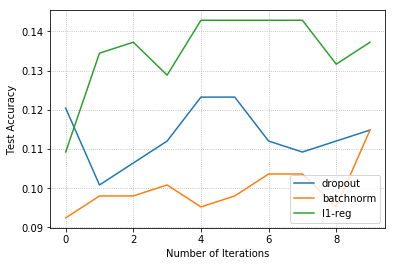

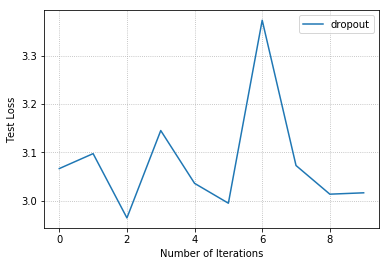

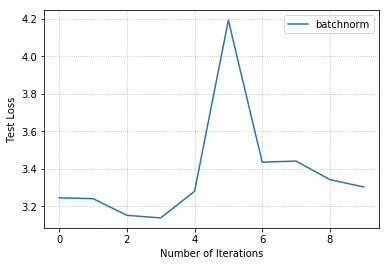

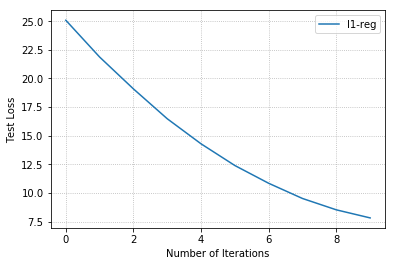

In [68]:
# compare accuracy
data = [[hist_mv2_dropout.history['val_acc'], "dropout"], [hist_mv2_batchnorm.history['val_acc'], "batchnorm"], [hist_mv2_l1reg.history['val_acc'], "l1-reg"]]
plotAccuracy(data, "Test Accuracy")
data = [[hist_mv2_dropout.history['val_loss'], "dropout"]]
plotAccuracy(data, "Test Loss")
data = [[hist_mv2_batchnorm.history['val_loss'], "batchnorm"]]
plotAccuracy(data, "Test Loss")
data = [[hist_mv2_l1reg.history['val_loss'], "l1-reg"]]
plotAccuracy(data, "Test Loss")

l1-regularization gives the best test accuracy, followed by dropout and batchnorm. In addition, l1-regularization gives continuous decrease in test loss, so with continued number of interations, the accuracy should improve further. In contrast, dropout and batchnorm give more of a scattered loss.

# Optimizer

Pick model using l1-regularization (best performing model from above) and evaluate three diﬀerent optimizers: SGD, Adam, RMSprop.

In [77]:
mv2_l1reg_sgd_transfer = Model(inputs=mobilenetv2_model.input, outputs=l1reg)
mv2_l1reg_adam_transfer = Model(inputs=mobilenetv2_model.input, outputs=l1reg)
mv2_l1reg_rmsprop_transfer = Model(inputs=mobilenetv2_model.input, outputs=l1reg)

# SGD optimizer
sgd = SGD()
adam = Adam()
rmsprop = RMSprop()

mv2_l1reg_sgd_transfer.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
mv2_l1reg_adam_transfer.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
mv2_l1reg_rmsprop_transfer.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])

#### SGD

SGD optimizer is already evaluated above with l1-reg.

#### Adam

In [78]:
print("batch_size: ", train_generator.batch_size)

for layer in mv2_l1reg_adam_transfer.layers:
    print(layer, layer.trainable)
    
mv2_l1reg_adam_transfer.summary()

hist_mv2_l1reg_adam = mv2_l1reg_adam_transfer.fit_generator(
        train_generator,
        steps_per_epoch=(train_generator.samples/train_generator.batch_size),
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=(test_generator.samples/test_generator.batch_size),
        verbose=1)

batch_size:  32
<keras.engine.input_layer.InputLayer object at 0x000001F9B22EA630> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B22F7908> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B22F7BA8> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B22F7DA0> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001F9B22F7C50> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B22CCF98> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B22875F8> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B147CDD8> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B14F6128> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B14E04E0> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B1573EB8> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B15F1748> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x00

Epoch 1/10
12/11 [================================] - 104s 9s/step - loss: 3.2732 - acc: 1.0000 - val_loss: 6.0182 - val_acc: 0.1120
Epoch 2/10
12/11 [================================] - 101s 8s/step - loss: 3.2390 - acc: 1.0000 - val_loss: 5.9007 - val_acc: 0.1317
Epoch 3/10
12/11 [================================] - 101s 8s/step - loss: 3.2085 - acc: 1.0000 - val_loss: 5.9911 - val_acc: 0.1176
Epoch 4/10
12/11 [================================] - 99s 8s/step - loss: 3.2186 - acc: 0.9888 - val_loss: 6.0050 - val_acc: 0.1092
Epoch 5/10
12/11 [================================] - 97s 8s/step - loss: 3.2084 - acc: 1.0000 - val_loss: 5.9924 - val_acc: 0.1232
Epoch 6/10
12/11 [================================] - 98s 8s/step - loss: 3.1854 - acc: 1.0000 - val_loss: 6.0468 - val_acc: 0.1092
Epoch 7/10
12/11 [================================] - 99s 8s/step - loss: 3.1808 - acc: 1.0000 - val_loss: 6.0317 - val_acc: 0.1092
Epoch 8/10
12/11 [================================] - 99s 8s/step - loss:

#### RMSprop

In [79]:
print("batch_size: ", train_generator.batch_size)

for layer in mv2_l1reg_rmsprop_transfer.layers:
    print(layer, layer.trainable)
    
mv2_l1reg_rmsprop_transfer.summary()

hist_mv2_l1reg_rmsprop = mv2_l1reg_rmsprop_transfer.fit_generator(
        train_generator,
        steps_per_epoch=(train_generator.samples/train_generator.batch_size),
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=(test_generator.samples/test_generator.batch_size),
        verbose=1)

batch_size:  32
<keras.engine.input_layer.InputLayer object at 0x000001F9B22EA630> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B22F7908> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B22F7BA8> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B22F7DA0> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001F9B22F7C50> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B22CCF98> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B22875F8> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B147CDD8> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B14F6128> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B14E04E0> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B1573EB8> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B15F1748> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x00

Epoch 1/10
12/11 [================================] - 116s 10s/step - loss: 3.4066 - acc: 0.9974 - val_loss: 5.9966 - val_acc: 0.1148
Epoch 2/10
12/11 [================================] - 108s 9s/step - loss: 3.2841 - acc: 1.0000 - val_loss: 6.0293 - val_acc: 0.1120
Epoch 3/10
12/11 [================================] - 109s 9s/step - loss: 3.2772 - acc: 1.0000 - val_loss: 6.0066 - val_acc: 0.1036
Epoch 4/10
12/11 [================================] - 111s 9s/step - loss: 3.2939 - acc: 0.9895 - val_loss: 6.0213 - val_acc: 0.1148
Epoch 5/10
12/11 [================================] - 110s 9s/step - loss: 3.2839 - acc: 1.0000 - val_loss: 5.9911 - val_acc: 0.1120
Epoch 6/10
12/11 [================================] - 99s 8s/step - loss: 3.2551 - acc: 1.0000 - val_loss: 5.9866 - val_acc: 0.1176
Epoch 7/10
12/11 [================================] - 105s 9s/step - loss: 3.2618 - acc: 1.0000 - val_loss: 5.9942 - val_acc: 0.1120
Epoch 8/10
12/11 [================================] - 111s 9s/step - 

#### Compare models

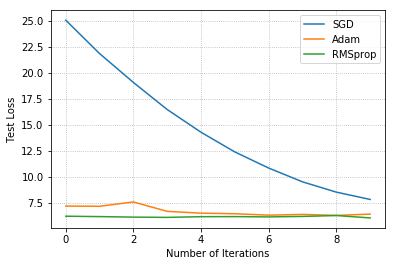

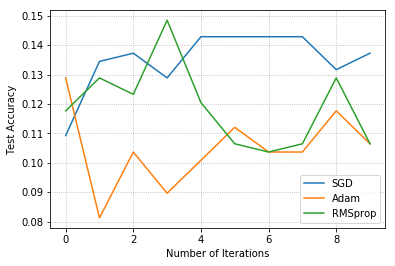

In [75]:
data = [[hist_mv2_l1reg.history['val_loss'], "SGD"], [hist_mv2_l1reg_adam.history['val_loss'], "Adam"], [hist_mv2_l1reg_rmsprop.history['val_loss'], "RMSprop"]]
plotAccuracy(data, "Test Loss")
data = [[hist_mv2_l1reg.history['val_acc'], "SGD"], [hist_mv2_l1reg_adam.history['val_acc'], "Adam"], [hist_mv2_l1reg_rmsprop.history['val_acc'], "RMSprop"]]
plotAccuracy(data, "Test Accuracy")

Comparing the performance, SGD is faster, since it takes about 5-6s/step, whereas Adam and RMSprop take 8-9s/step. On the other hand RMSprop reaches training accuracy the fastests, followed closely by Adam, whereas SGD take longer. Therefore with an optimizer such as RMSprop, although it takes 8-9s/step, we can stop training much more quickly since it reaches almost perfect training accuracy within a couple epochs. In contrast, SGD reaches training accuracy more incrementally, and takes 10 epoches without reaching perfect training accuracy. However this may be why it is better able to react and increasing test accuracy more incrementally as well.

# Multi-task Learning

In [81]:
mobilenetv2_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))

In [ ]:
epochs = 10

#mobilenetv2_model.summary()
for layer in mobilenetv2_model.layers:
    layer.trainable = False

# last layers output
x = mobilenetv2_model.layers[-1].output

# Flatten as before
x = Flatten()(x)

# Apply l1-reg
l1reg = Dense(256, activation='relu', name='l1reg1')(x)
#l1reg = Dropout(0.5, name='dropout_l1reg')(l1reg)
l1reg = Dense(12, activation='softmax', kernel_regularizer=l1(0.1), activity_regularizer=l1(0.1), name='l1reg2')(l1reg)

# regression task
#x = keras.layers.concatenate([x, bb_input])
regression_task = Dense(256, activation='relu', kernel_regularizer=l1(0.1), activity_regularizer=l1(0.1), name='regression_task1')(x)
#regression_task = Dropout(0.5, name='dropout_regt')(regression_task)
regression_task = Dense(4, activation='linear', name='regression_task2')(regression_task)

# Transfer models
mv2_multitask_transfer = Model(inputs=mobilenetv2_model.input, outputs=[l1reg, regression_task])

sgd = SGD(lr=0.0008)
mv2_multitask_transfer.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [128]:
print("batch_size: ", train_generator.batch_size)

for layer in mv2_multitask_transfer.layers:
    print(layer, layer.trainable)
    
mv2_multitask_transfer.summary()

hist_mv2_multitask = mv2_multitask_transfer.fit(
        X, [y, bb_input_train],
        batch_size=32,
        epochs=epochs,
        validation_data=(X, [y, bb_input_train]),
        verbose=1)

batch_size:  32
<keras.engine.input_layer.InputLayer object at 0x000001F9B5357320> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B5AE10B8> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B59466D8> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B5326668> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001F9B5696A20> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B5343710> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B5401160> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B53E3C18> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B52C8668> False
<keras.layers.convolutional.Conv2D object at 0x000001F9B52BD208> False
<keras.layers.normalization.BatchNormalization object at 0x000001F9B5268EF0> False
<keras.layers.advanced_activations.ReLU object at 0x000001F9B527C5F8> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x00

359/359 [==============================] - 66s 185ms/step - loss: 2166.1465 - l1reg2_loss: 0.3470 - regression_task2_loss: 2162.6483 - l1reg2_acc: 0.8663 - regression_task2_acc: 0.5933 - val_loss: 2097.1269 - val_l1reg2_loss: 3.3075 - val_regression_task2_loss: 2090.6681 - val_l1reg2_acc: 0.0669 - val_regression_task2_acc: 0.5905
Epoch 2/10
359/359 [==============================] - 68s 190ms/step - loss: 2135.6020 - l1reg2_loss: 0.2159 - regression_task2_loss: 2132.2349 - l1reg2_acc: 0.9415 - regression_task2_acc: 0.5850 - val_loss: 2052.7090 - val_l1reg2_loss: 3.5069 - val_regression_task2_loss: 2046.0509 - val_l1reg2_acc: 0.0724 - val_regression_task2_acc: 0.5905
Epoch 3/10
359/359 [==============================] - 72s 201ms/step - loss: 2107.9897 - l1reg2_loss: 0.2086 - regression_task2_loss: 2104.6298 - l1reg2_acc: 0.9415 - regression_task2_acc: 0.5766 - val_loss: 1995.2080 - val_l1reg2_loss: 3.2533 - val_regression_task2_loss: 1988.8035 - val_l1reg2_acc: 0.0864 - val_regression_

KeyboardInterrupt: 

# Additional Annotations